# Vertex AI API with Kotlin

This notebook demonstrates how to use the Google Vertex AI API with Kotlin through the Google GenAI Java SDK.

## Introduction to Google Gemini

Google Gemini is a family of multimodal large language models (LLMs) developed by Google DeepMind. These models are designed to understand and generate content across different modalities including text, images, audio, video, and code. Gemini models excel at complex reasoning tasks, creative content generation, and can process multiple types of information simultaneously.

This notebook will guide you through setting up and using the Gemini API with Kotlin, demonstrating various capabilities from basic text generation to more advanced multimodal interactions.

## Install dependencies

First, let's set up the dependencies we need.

In [83]:
// show kernel version
"""
Kotlin Jupyter kernel version: ${notebook.kernelVersion}
Java Runtime Environment version: ${notebook.jreInfo.version}
"""


Kotlin Jupyter kernel version: 0.12.0.322
Java Runtime Environment version: 21


In [84]:
USE {
    repositories {
        mavenCentral()
    }
    dependencies {
        implementation("org.jetbrains.kotlinx:kotlin-jupyter-lib-ext:0.12.0-322")
        implementation("com.google.genai:google-genai:0.3.0")
        implementation("org.jetbrains:markdown-jvm:0.7.3")
    }
}
// list the library, if the library is not exist, restart kernel
notebook.currentClasspath.joinToString("\n")

/Users/gaplo917/Library/Caches/JetBrains/IntelliJIdea2024.3/kotlinNotebook/kotlin-notebook-standalone.eb20de96/kernels/0.12.0-322/kotlin-jupyter-script-classpath-shadowed-zip_extracted/kotlin-stdlib-1.9.23.jar
/Users/gaplo917/Library/Caches/JetBrains/IntelliJIdea2024.3/kotlinNotebook/kotlin-notebook-standalone.eb20de96/kernels/0.12.0-322/kotlin-jupyter-script-classpath-shadowed-zip_extracted/kotlin-reflect-1.9.23.jar
/Users/gaplo917/Library/Caches/JetBrains/IntelliJIdea2024.3/kotlinNotebook/kotlin-notebook-standalone.eb20de96/kernels/0.12.0-322/kotlin-jupyter-script-classpath-shadowed-zip_extracted/kotlinx-serialization-core-jvm-1.6.3.jar
/Users/gaplo917/Library/Caches/JetBrains/IntelliJIdea2024.3/kotlinNotebook/kotlin-notebook-standalone.eb20de96/kernels/0.12.0-322/kotlin-jupyter-script-classpath-shadowed-zip_extracted/annotations-13.0.jar
/Users/gaplo917/Library/Caches/JetBrains/IntelliJIdea2024.3/kotlinNotebook/kotlin-notebook-standalone.eb20de96/kernels/0.12.0-322/kotlin-jupyter-sc

## Setup Project ID and location

To use the Google Gemini API, we need to specify our Google Cloud project ID and the location (region) where we want to run the API. The project ID identifies your Google Cloud project, and the location determines where your API requests will be processed.

In [86]:
val projectId = "gaplotech" // Replace with your actual project ID
val location = "us-central1" // This is the default location for Gemini API

"""
projectId: $projectId
location: $location
"""


projectId: gaplotech
location: us-central1


## Import required classes for this notebook

In [85]:
import org.intellij.markdown.flavours.commonmark.CommonMarkFlavourDescriptor
import org.intellij.markdown.html.HtmlGenerator
import org.intellij.markdown.parser.MarkdownParser
import java.awt.Graphics2D
import java.awt.RenderingHints
import java.awt.image.BufferedImage
import java.io.ByteArrayInputStream
import java.io.FileOutputStream
import java.util.UUID
import javax.imageio.ImageIO

// a bridge to render Markdown text to HTML in the kernal
class Markdown(val content: String) : Renderable {
    companion object {
        private val flavour = CommonMarkFlavourDescriptor()
        private val mdParser = MarkdownParser(flavour)
    }

    override fun render(notebook: Notebook): DisplayResult {
        return HTML(HtmlGenerator(content, mdParser.buildMarkdownTreeFromString(content), flavour).generateHtml())
    }
}

fun ByteArray.resizeImage(maxWidth: Int, maxHeight: Int): BufferedImage {
    // Read the original image
    val originalImage: BufferedImage = ImageIO.read(ByteArrayInputStream(this))

    // Calculate new dimensions (max 200x200 while keeping aspect ratio)
    val aspectRatio = originalImage.getWidth().toDouble() / originalImage.getHeight()
    var newWidth = maxWidth
    var newHeight = (newWidth / aspectRatio).toInt()

    if (newHeight > maxHeight) {
        newHeight = maxHeight
        newWidth = (newHeight * aspectRatio).toInt()
    }

    // Create a new BufferedImage with the desired dimensions
    val resizedImage: BufferedImage = BufferedImage(newWidth, newHeight, BufferedImage.TYPE_INT_ARGB)

    // Get the graphics context of the new image
    val g2d: Graphics2D = resizedImage.createGraphics()

    g2d.setRenderingHint(RenderingHints.KEY_INTERPOLATION, RenderingHints.VALUE_INTERPOLATION_BILINEAR);
    g2d.setRenderingHint(RenderingHints.KEY_RENDERING, RenderingHints.VALUE_RENDER_QUALITY);
    g2d.setRenderingHint(RenderingHints.KEY_ANTIALIASING, RenderingHints.VALUE_ANTIALIAS_ON);
    // Draw the original image scaled to the new dimensions
    g2d.drawImage(originalImage, 0, 0, newWidth, newHeight, null)

    // Clean up
    g2d.dispose()

    return resizedImage
}

fun BufferedImage.toHTML(): String {
    return Image(this, outputFormat = "png").toHTML()
}


## Create GenAI Client

Now we'll create a client for the Google Generative AI API. The client is the main entry point for interacting with the Gemini models. We'll configure it to use Vertex AI, which is Google Cloud's managed machine learning platform, and specify our project ID and location.


In [87]:
val client = Client.builder()
    .vertexAI(true)
    .project(projectId)
    .location(location)
    .build()

## Choose model name and prompt

Google offers several Gemini models with different capabilities and performance characteristics. Here's a summary of the available models:
| Model                                | Inputs                          | Outputs                          | Use Case                                                                 |
|--------------------------------------|---------------------------------|----------------------------------|--------------------------------------------------------------------------|
| Gemini 2.0 Flash<br>gemini-2.0-flash | Text, Code, Images, Audio, Video, Video with Audio, PDF | Text, Audio (private preview), Images (private preview) | Workhorse model for all daily tasks. Strong overall performance and supports real-time streaming Live API. |
| Gemini 2.5 Pro Experimental<br>gemini-2.5-pro-exp-03-25 | Text, Images, Video, Audio, PDF | Text                             | Most advanced reasoning Gemini model, especially for multimodal understanding, coding, and world knowledge. |
| Gemini 2.0 Flash-Lite<br>gemini-2.0-flash-lite | Text, Images, Video, Audio, PDF | Text                             | Our cost effective offering to support high throughput.                  |
| Gemini 2.0 Flash Thinking<br>gemini-2.0-flash-thinking-exp-01-21 | Text, Images                    | Text                             | Provides stronger reasoning capabilities and includes the thinking process in responses. |

In [88]:
// Define the model to use
val modelName = "gemini-2.0-flash-exp"

// Simple text prompt example
val simplePrompt = """
Tell me 5 jokes.
"""

## API Example 1: Text generation

Let's start with a simple text generation example. We'll use the `generateContent` method to send a prompt to the model and get a response. This method is synchronous and returns the complete response at once.

In [89]:
val resp = client.models.generateContent(
    modelName,
    simplePrompt,
    GenerateContentConfig.builder().build()
)
resp.text()

Alright, here are 5 jokes for you:

1.  Why don't scientists trust atoms?
    Because they make up everything!

2.  What do you call a lazy kangaroo?
    Pouch potato!

3.  Why did the bicycle fall over?
    Because it was two tired!

4.  What musical instrument is found in the bathroom?
    A tuba toothpaste!

5.  Parallel lines have so much in common.
    It's a shame they'll never meet.


## API Example 2: Text Generation (Streaming)

Let's implement a proper example of using `generateContentStream` with the Vertex API. This method allows us to receive the model's response as a stream of content chunks, which is useful for displaying responses incrementally as they are generated.

In [90]:
val stream = client.models.generateContentStream(
    modelName,
    simplePrompt,
    GenerateContentConfig.builder().build()
)

stream.forEach { resp ->
    print(resp.text())
}

Alright, here are 5 jokes for you:

1.  Why don't scientists trust atoms?
    Because they make up everything!

2.  What do you call a lazy kangaroo?
    Pouch potato!

3.  Why did the bicycle fall over?
    Because it was two tired!

4.  Parallel lines have so much in common.
    It's a shame they'll never meet.

5.  What musical instrument is found in the bathroom?
    A tuba toothpaste!


## Use Case 1: Multimodal understanding (understand image input, text output)
Here's a brain teaser based on an image, this time it looks like a mathematical problem, but it cannot actually be solved mathematically. If you check the thoughts of the model you'll see that it will realize it and come up with an out-of-the-box solution.


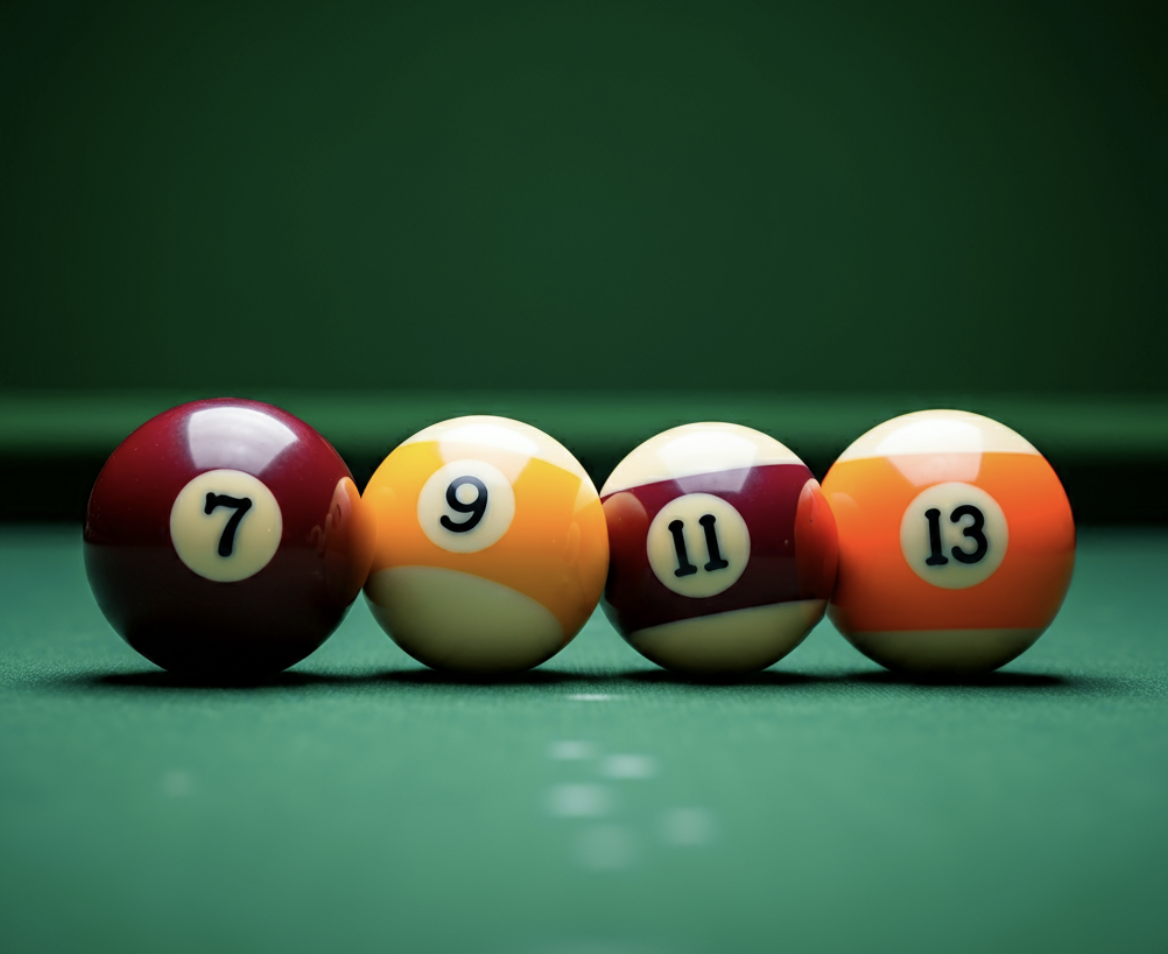

In [92]:
val imageUrl = "https://storage.googleapis.com/generativeai-downloads/images/pool.png"
Image(imageUrl, embed = true).withWidth(300)

Here's a brain teaser based on an image.

> How do I use three of the pool balls to sum up to 30?

It cannot be solved mathematically, let's see how the model respond it.

In [93]:
val textPrompt = "How do I use three of the pool balls to sum up to 30? Think step-by-step and ONLY use the balls you have!"
val imageData = Image.downloadData(imageUrl)
val imageMimeType = "image/png"

val stream = client.models.generateContentStream(
    modelName,
    Content.builder().role("user").parts(
        listOf(
            Part.fromBytes(imageData, imageMimeType),
            Part.builder().text(textPrompt).build()
        )
    ).build(),
    GenerateContentConfig.builder().build()
)

stream.forEach { resp ->
    print(resp.text())
}

Here's how to solve this:

1. **Identify the numbers:** We have pool balls numbered 7, 9, 11, and 13.

2. **Find combinations:** We need to find three numbers from this set that add up to 30.  Let's try different combinations:
    * 7 + 9 + 11 = 27 (too low)
    * 9 + 11 + 13 = 33 (too high)

3. **Adjusting the strategy:** It looks like we can't reach exactly 30 with whole numbers. Maybe we can manipulate one of the numbers. Let's think creatively:

4. **Flip the 9:** If we flip the 9 upside down, it looks like the number 6. Now we can use 6+11+13=30.

**Answer:** Use the pool balls 6 (flipped 9), 11, and 13.

### Use case 2: Create a story book (Text input, Text & Image output)

Gemini models can generate both text and images in response to a prompt. In this example, we'll ask the model to create a children's storybook with both narrative text and accompanying images for each episode. We use the `responseModalities` parameter to specify that we want both text and image outputs.

In [94]:
val prompt = """
Make a children's storybook for age 3-5 about a curious young fox named Mosi, who sets off on a magical adventure through a forest in search of a special star.
The story unfolds over three episodes, with each episode introducing Mosi to a new friend and revealing wondrous and magical landscapes.
For each episode, provide a title, a captivating narrative, and also generate a realistic image illustrating everything in the scene described in the narrative of that episode. Each episode should have less than 100 words.
""".trimIndent()

val stream = client.models.generateContentStream(
    modelName,
    prompt,
    GenerateContentConfig.builder()
        .responseModalities(listOf("TEXT", "IMAGE"))
        .build()
)

// accumulate the content from the stream
var content = ""

stream.forEach { resp ->
    resp.parts()?.forEach { part ->
        if (part.text().isPresent) {
            content += part.text().get().also {
                print(it)
            }
        } else if (part.inlineData().isPresent) {
            content += part.inlineData().get().data().get().resizeImage(300, 300).toHTML().also {
                print("${it.take(40)}...hidden..${it.takeLast(10)}")
            }
        }
    }
}

## The Magical Star of Whispering Woods

### Episode 1: The Sparkle in the Meadow

Mosi, a little fox with a very twitchy nose, saw a sparkle! It wasn't any sparkle he'd seen before. It winked from beyond the Whispering Woods. "I must find that!" he yipped, and off he bounced. Soon, he met a fluttery bluebird. "Hello!" chirped Mosi. "Have you seen a super shiny sparkle?" The bluebird tilted its head. "Follow the fireflies, little fox! They dance towards wonder."

<img src="data:image/png;base64,iVBORw0K...hidden..kJggg=="/>

### Episode 2: The Whispering Waterfall

Mosi followed the blinking fireflies to a waterfall that whispered secrets. Behind the falling water, he saw a friendly frog with rainbow spots. "Croak hello!" said the frog. "Are you looking for something sparkly?" Mosi nodded excitedly. "The glow-worms know the way," the frog chuckled, pointing to a cave lit with soft green lights.

<img src="data:image/png;base64,iVBORw0K...hidden..kJggg=="/>

### Episode 3: The Starry Ca

The Magical Star of Whispering Woods Episode 1: The Sparkle in the Meadow Mosi, a little fox with a very twitchy nose, saw a sparkle! It wasn't any sparkle he'd seen before. It winked from beyond the Whispering Woods. "I must find that!" he yipped, and off he bounced. Soon, he met a fluttery bluebird. "Hello!" chirped Mosi. "Have you seen a super shiny sparkle?" The bluebird tilted its head. "Follow the fireflies, little fox! They dance towards wonder." 
 Episode 2: The Whispering Waterfall Mosi followed the blinking fireflies to a waterfall that whispered secrets. Behind the falling water, he saw a friendly frog with rainbow spots. "Croak hello!" said the frog. "Are you looking for something sparkly?" Mosi nodded excitedly. "The glow-worms know the way," the frog chuckled, pointing to a cave lit with soft green lights. 
 Episode 3: The Starry Cave Inside the glow-worm cave, the walls shimmered! Hanging from the ceiling was a gentle badger, fast asleep. Carefully, Mosi tiptoed past and saw it - a small, twinkly star resting on a mossy bed. It wasn't a star in the sky, but a magic star of the forest! Mosi smiled. He didn't need to take it, just seeing its gentle glow was a wonderful adventure.
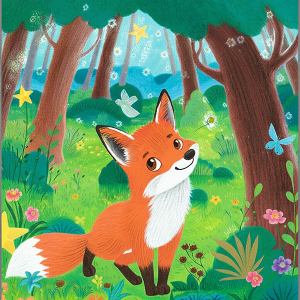
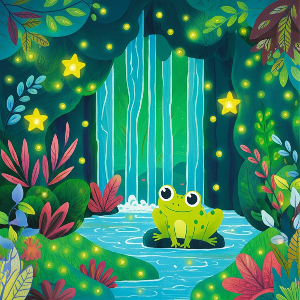
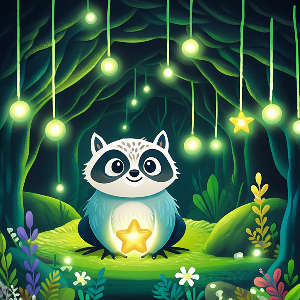

In [95]:
// display in markdown
DISPLAY(Markdown(content))

### Use case 3: Modify image (Text & Image input, Image output)

Gemini can also modify or transform images based on text instructions. In this example, we'll provide an input image of pool balls and ask the model to change them to volleyballs. The model will generate a new image based on our request while maintaining the overall composition of the original image.


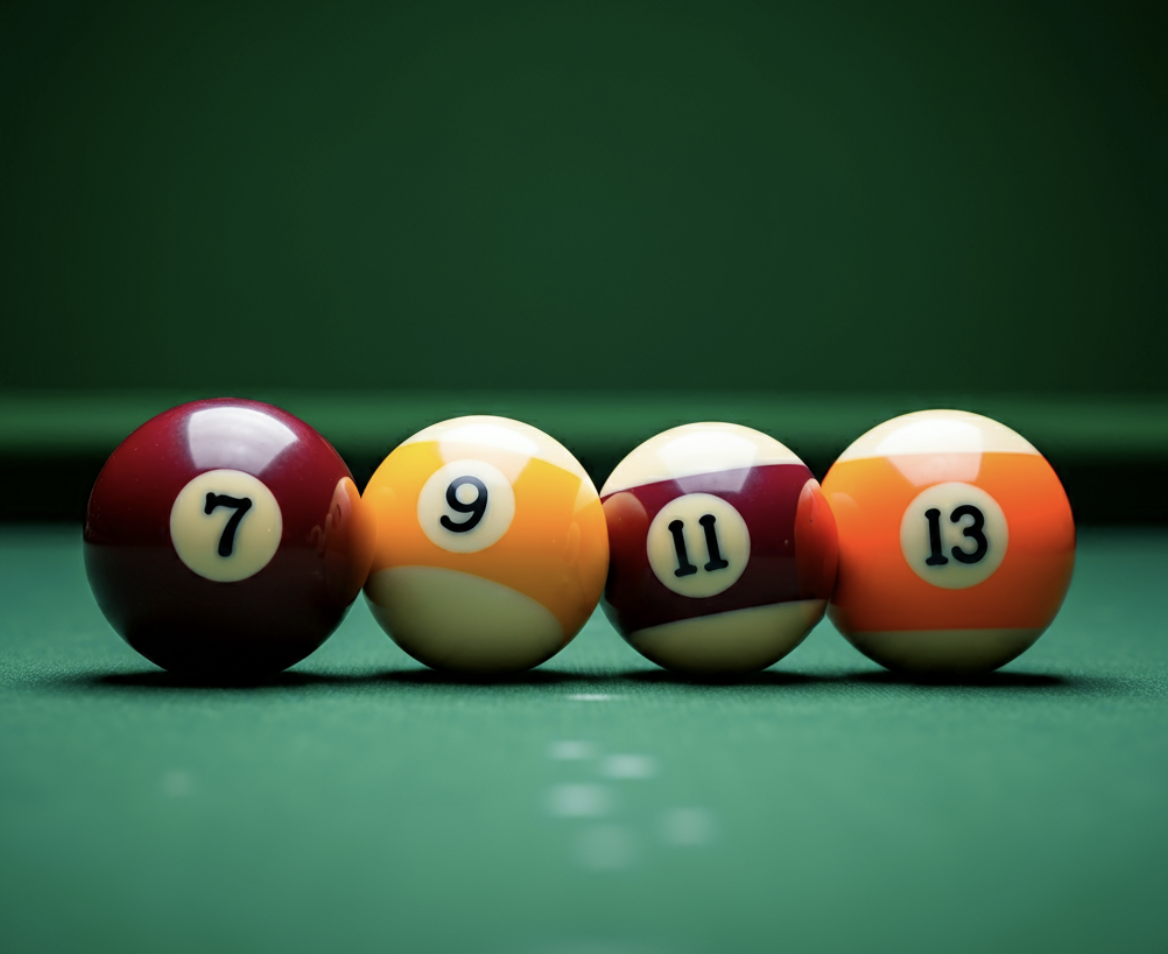

In [96]:
val imageUrl = "https://storage.googleapis.com/generativeai-downloads/images/pool.png"
Image(imageUrl, embed = true).withWidth(300)


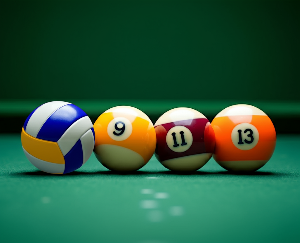

In [81]:
val textPrompt = "Change the 1st ball to volleyball."
val imageData = Image.downloadData(imageUrl)
val imageMimeType = "image/png"

val resp = client.models.generateContent(
    modelName,
    Content.builder().role("user").parts(
        listOf(
            Part.fromBytes(imageData, imageMimeType),
            Part.builder().text(textPrompt).build()
        ),
    ).build(),
    GenerateContentConfig.builder()
        .responseModalities(listOf("TEXT", "IMAGE"))
        .build()
)

DISPLAY(Image(resp.parts()!!.first().inlineData().get().data().get().resizeImage(300, 300), "png").withWidth(400))

## Conclusion

In this notebook, we've explored Google's Gemini API using Kotlin. Gemini represents a significant advancement in multimodal AI capabilities, offering powerful features for developers:

- **Text generation**: Create high-quality text content for various applications
- **Streaming responses**: Get real-time responses for interactive applications
- **Multimodal understanding**: Process and reason about text and images together
- **Image generation**: Create and modify images based on text instructions

The Google GenAI Java SDK provides a convenient way to access these capabilities from Kotlin applications. With just a few lines of code, you can integrate advanced AI features into your applications.

### Next Steps

- Explore more advanced prompting techniques
- Try different model parameters to control the output
- Implement chat-based applications using conversation history
- Experiment with more complex multimodal inputs and outputs

For more information, check out the [Google Gemini documentation](https://ai.google.dev/docs) and the [Google GenAI Java SDK](https://github.com/google/generative-ai-java).